# Introduction

### Road accidents constitute a major problem in our societies around the world. The World Health Organization (WHO) estimated that 1.25 million deaths were related to road traffic injuries in the year 2010. For the year 2016, the USA alone had recorded 37, 461 motor vehicle crash-related deaths, averaging around 102 people per day. In Europe, the statistics also indicate that each minute, there are 50 road deaths recorded in the year 2017. Can machine learning help us understand the causes and the factors that affect car crash severity?

# BARCELONA VEHICLE ACCIDENTS 

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from datetime import datetime
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import folium
import requests
from dateutil.parser import parse
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print(sns.__version__)

from IPython.display import HTML


df = pd.read_csv("project_data.csv")
df.head()
# df.rename(columns={"neighborhoodname" : "neighbourhoodname"}, inplace=True)

0.9.0


,date,districtname,neighbourhoodname,streetname,monthname,vehicletype,gender,persontype,severity,age,lat,long
0,2010-01-01 07:00:00,Eixample,la Dreta de l'Eixample,Tetuan,January,Motorcycle,Man,Driver,Minor,30,"4583198,28","431179,27"
1,2010-01-01 07:00:00,Eixample,la Dreta de l'Eixample,Tetuan,January,Motorcycle,Man,Driver,Minor,39,"4583198,28","431179,27"
2,2010-01-01 14:00:00,Eixample,el Fort Pienc,Sardenya,January,Motorcycle,Man,Driver,Minor,39,"4583631,60","431444,51"
3,2010-01-01 20:00:00,Sant Andreu,la Sagrera,Meridiana,January,Motorcycle,Man,Driver,Minor,34,"4586479,84","432062,05"
4,2010-01-01 21:00:00,Sant Martí,la Vila Olímpica del Poblenou,Icària,January,Tour vehicle,Woman,Driver,Minor,32,"4582584,02","432826,97"


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66707 entries, 0 to 66706
Data columns (total 12 columns):
date                 66707 non-null object
districtname         66707 non-null object
neighbourhoodname    66707 non-null object
streetname           66707 non-null object
monthname            66707 non-null object
vehicletype          66707 non-null object
gender               66707 non-null object
persontype           66707 non-null object
severity             66707 non-null object
age                  66707 non-null object
lat                  66707 non-null object
long                 66707 non-null object
dtypes: object(12)
memory usage: 6.1+ MB


In [3]:
# Counting NaN values if they exist
df.isnull().sum().any()

False

In [4]:
df['date'] = pd.to_datetime(df['date'])


In [5]:
from IPython.display import Image
from IPython.core.display import HTML 

start_year = df['date'].dt.year.min()
end_year = df['date'].dt.year.max()

fatal = df.severity.value_counts()['Fatal']
serious = df.severity.value_counts()['Serious']
minor = df.severity.value_counts()['Minor']

print(f"Total death in vehicle accidents since {start_year} up to {end_year} is {fatal}")
print(f"while total serious injures and minor injures reach {serious} and {minor} respectively")

Image(url="https://i.i-sgcm.com/news/article_advice/2007/29_p1_s_1.jpg")

 

Total death in vehicle accidents since 2010 up to 2015 is 178
while total serious injures and minor injures reach 1437 and 65092 respectively


# Looking into dates #

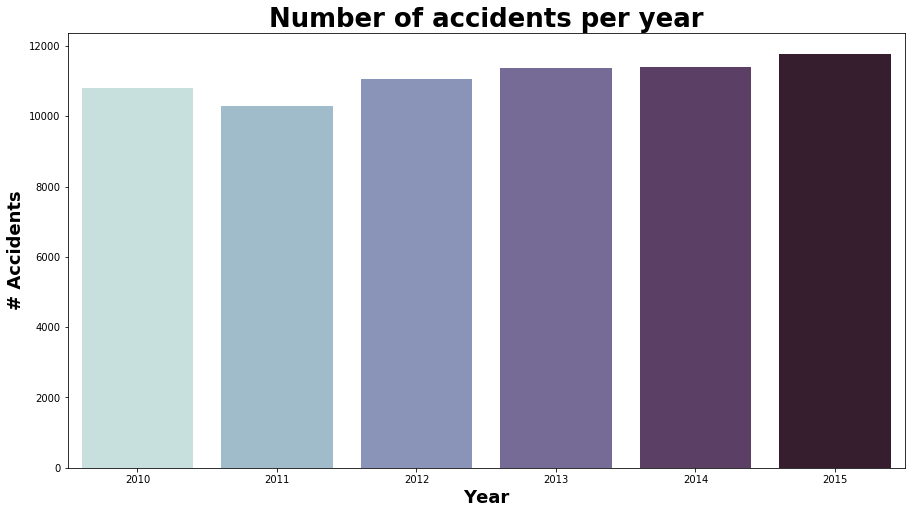

In [6]:
# Number of accidents per year

plt.figure(figsize=(15, 8))
palette = sns.cubehelix_palette(6, start=.8, rot=-0.55)
ax = sns.barplot(x=df['date'].dt.year.value_counts().index,
                 y=df['date'].dt.year.value_counts(), palette=palette)

plt.title("Number of accidents per year", fontsize = 26).set_weight('bold')
ax.set_xlabel('Year', fontsize=18).set_weight('bold')
ax.set_ylabel('# Accidents', fontsize=18).set_weight('bold')
plt.show()

## We see clearly, that the number of vehicle accidents incresed over the years







In [7]:
import calendar

# Number of accidents per month
accidents_month = df.groupby(df['date'].dt.month).count().date

# Month integers into month names
accidents_month.index = [calendar.month_name[x] for x in range(1, 13)]

accidents_month

January      5168
February     5283
March        5664
April        5512
May          5871
June         5825
July         5966
August       4204
September    5438
October      6042
November     5843
December     5891
Name: date, dtype: int64

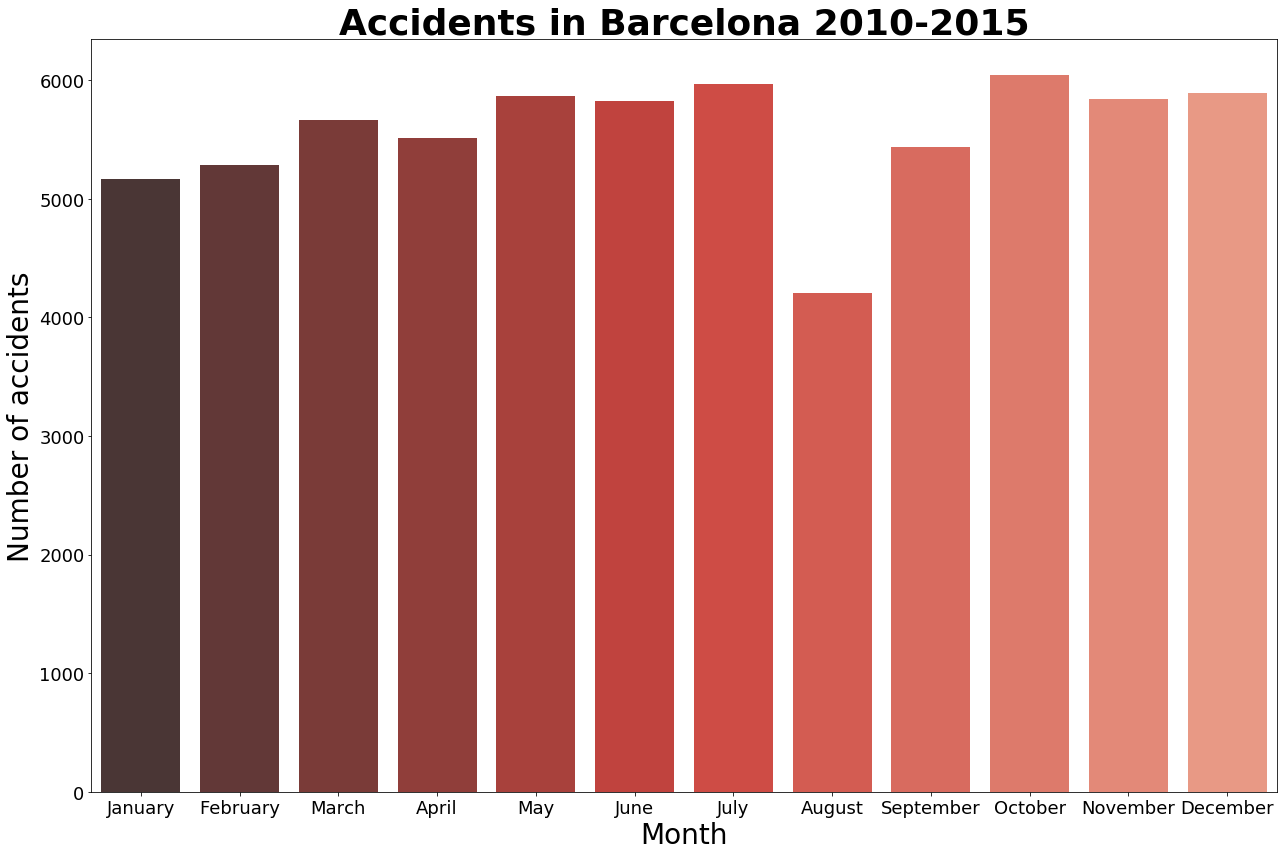

In [8]:
plt.figure(figsize=(18,12))

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)

sns.barplot(x=accidents_month.index, y=accidents_month, palette="Reds_d")

plt.title('Accidents in Barcelona 2010-2015', fontsize=36).set_weight('bold')
plt.xlabel('Month', fontsize=28)
plt.ylabel('Number of accidents', fontsize=28)

plt.tight_layout()
plt.show()

## As we can observe, the number of accidents dereases in August. One reason could be that fewer people are driving to work in this month


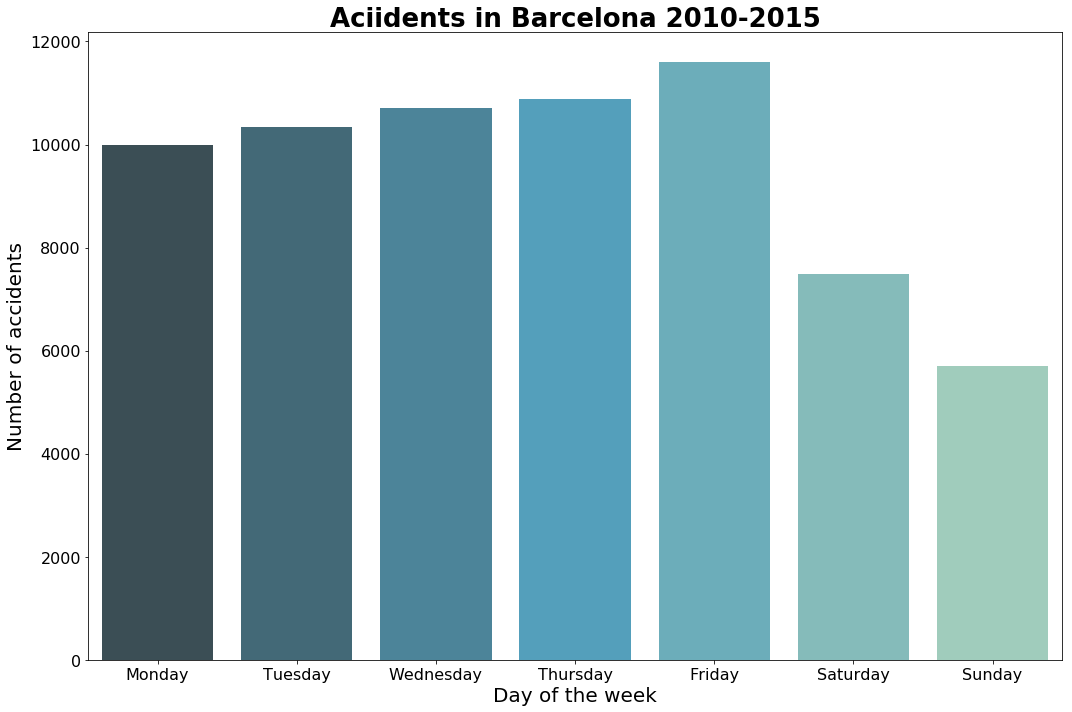

In [9]:
plt.figure(figsize=(15,10))

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

# Number of accidents per day of the week
accidents_day = df.groupby(df['date'].dt.dayofweek).count().date

# Replace the day integers by day names
accidents_day.index=[calendar.day_name[x] for x in range(0,7)]


sns.barplot(x=accidents_day.index, y=accidents_day, palette="GnBu_d")

plt.title('Aciidents in Barcelona 2010-2015', fontsize=26).set_weight('bold')
plt.xlabel('Day of the week', fontsize = 20)
plt.ylabel('Number of accidents', fontsize = 20)

plt.tight_layout()
plt.show()

## As shown in the plot above, the number of vehicle accidents decrease at the weekend. 


## The next plot depicts the number of accidents during each day of the year. As we can observe, there are mostly from 10 to 50 accidents per day and the number of accidents on friday is definitely much higher than the number of accidents on sunday.


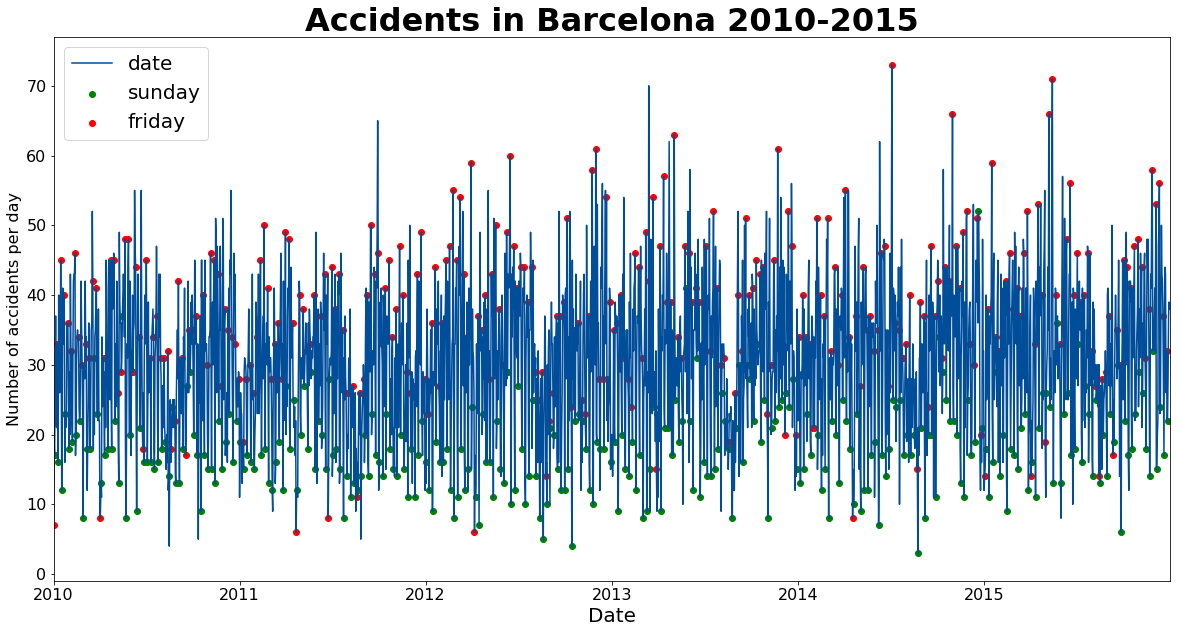

In [10]:
# Difference in number of accidenst on sunday and friday

plt.figure(figsize=(20,10))

accidents = df.groupby(df['date'].dt.date).count().date
accidents.plot(color='#004d99')

# Sunday
sundays = df.groupby(df[df['date'].dt.dayofweek==6].date.dt.date).count().date
plt.scatter(sundays.index, sundays, color='green', label='sunday')

# Friday
fridays = df.groupby(df[df['date'].dt.dayofweek==4].date.dt.date).count().date
plt.scatter(fridays.index, fridays, color = 'red', label='friday')

plt.title('Accidents in Barcelona 2010-2015', fontsize=32).set_weight('bold')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of accidents per day', fontsize=16)
plt.legend(loc=2, fontsize=20)
plt.show()


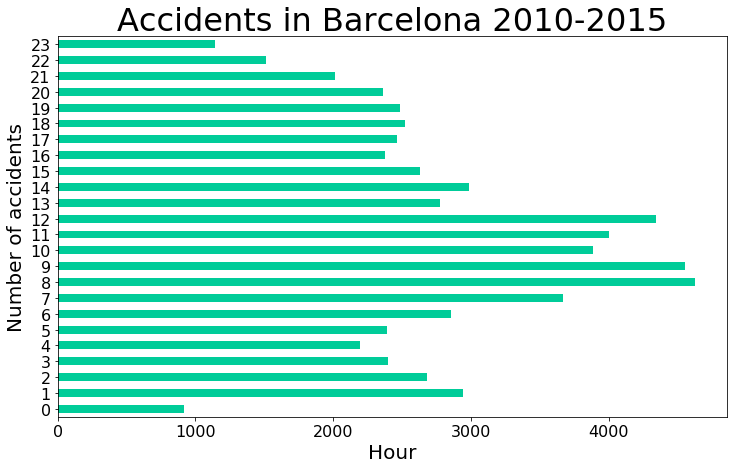

In [11]:
# Number of accidents per hour

plt.figure(figsize=(20,10))

accidents_hour = df.groupby(df['date'].dt.hour).count().date

accidents_hour.plot(kind='barh',figsize=(12,7), color='#00cc99')

plt.title('Accidents in Barcelona 2010-2015', fontsize=32)
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Number of accidents', fontsize=20)
plt.show()


## As we can see in the plot, the greatest number of accidents occur in morning hours between 7 and 12


<Figure size 1440x2520 with 0 Axes>

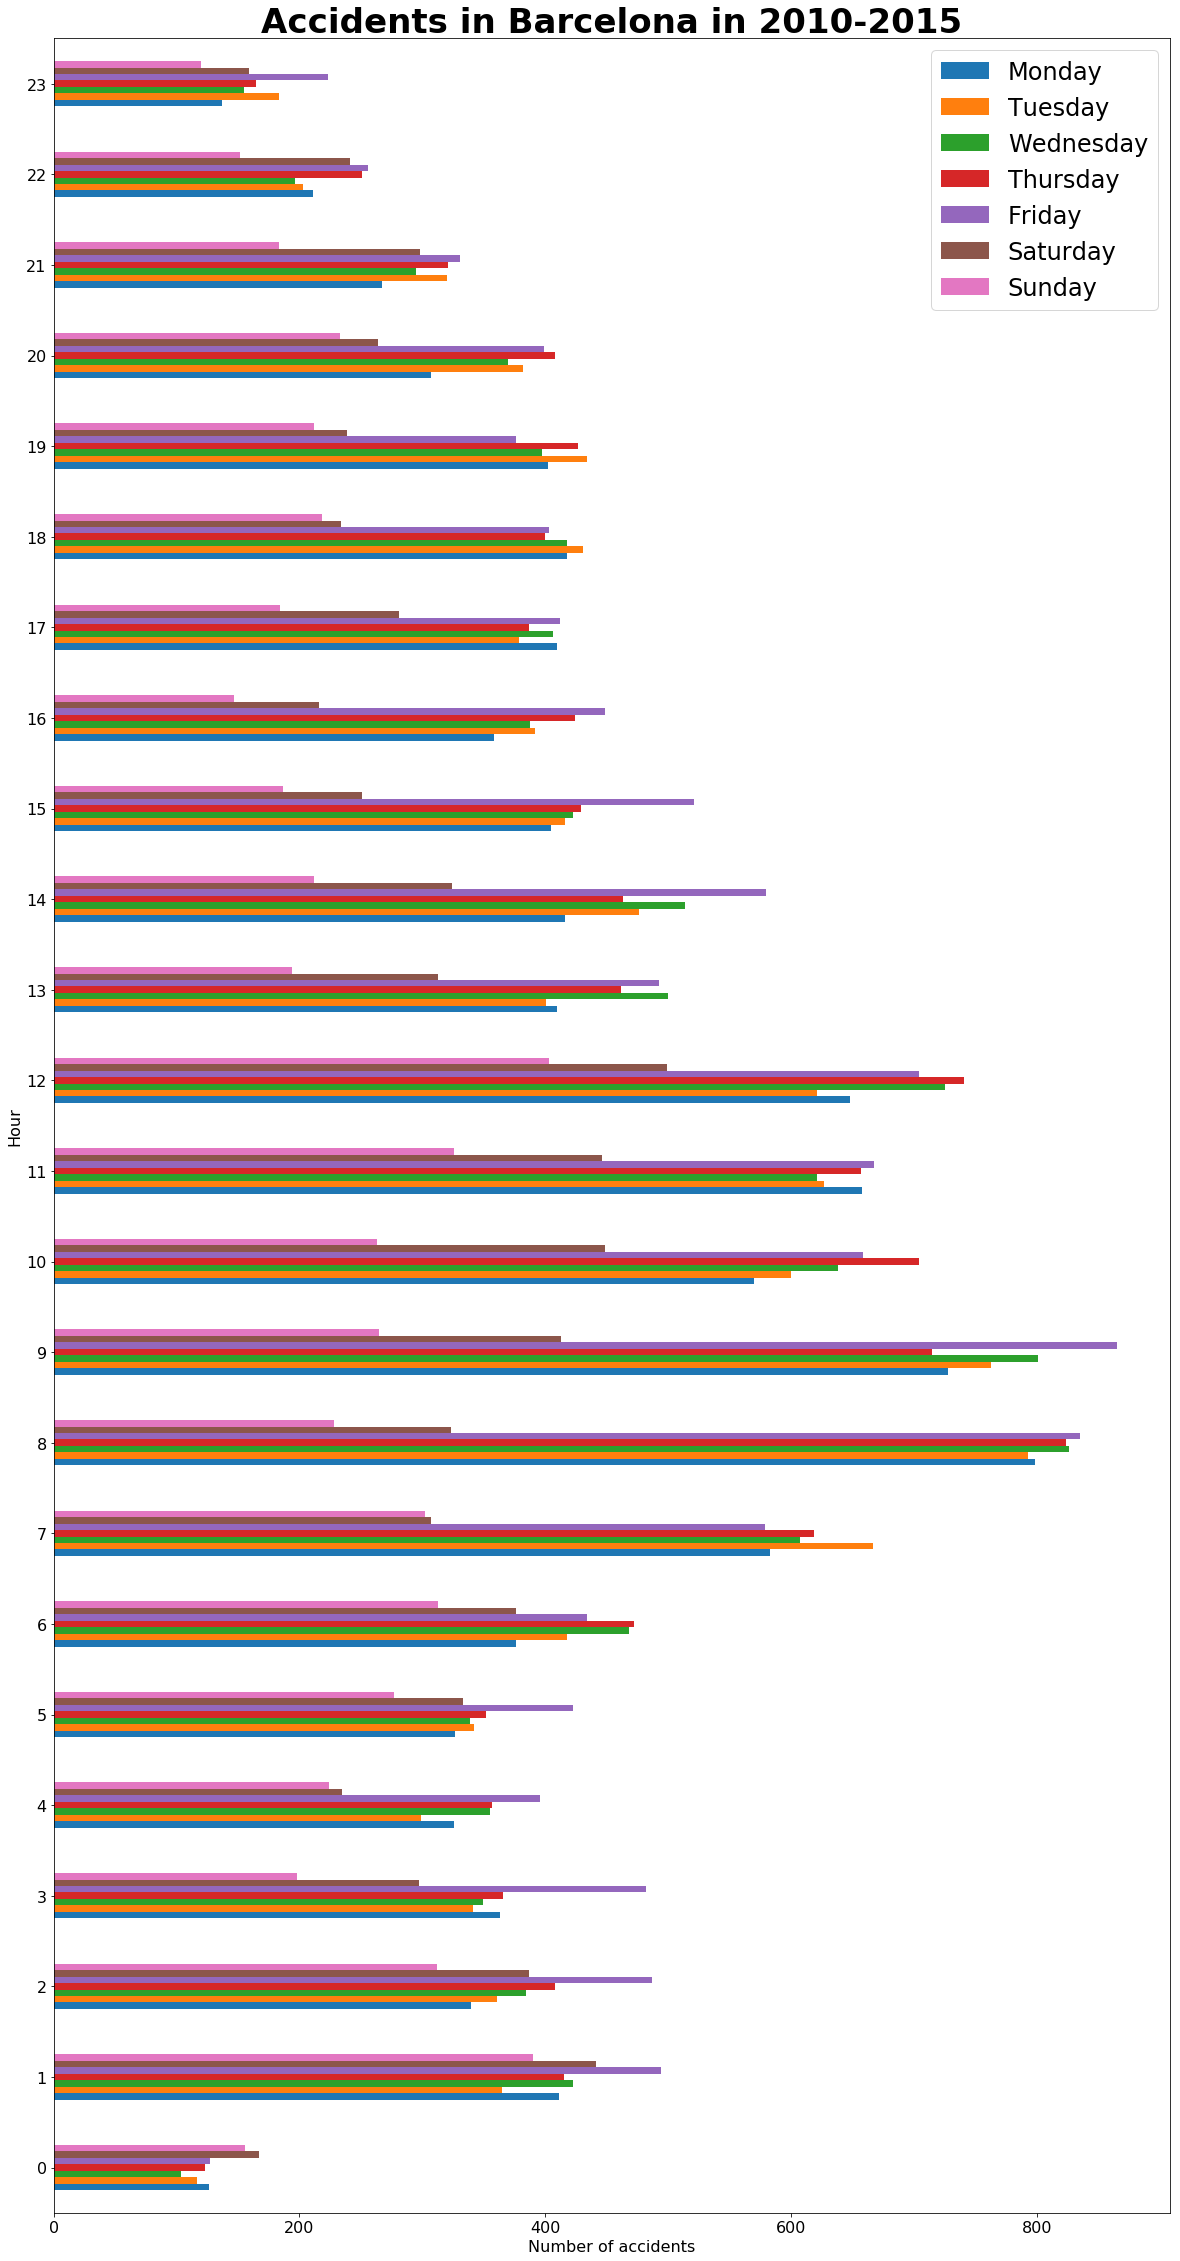

In [12]:
# Number of accidents per hour and day

plt.figure(figsize=(20, 35))

accidents_hour_day = df.groupby([df['date'].dt.hour.rename('hour'),
                                df['date'].dt.dayofweek.rename('day')]).count().date

accidents_hour_day.unstack().plot(kind='barh', figsize=(20, 40))



plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=24)
plt.title('Accidents in Barcelona in 2010-2015',fontsize=34).set_weight('bold')
plt.xlabel('Number of accidents',fontsize=16)
plt.ylabel('Hour',fontsize=16)
plt.show()

## Using horizontal plot for better visualisation we can easily observe, there are more accidents at night on weekends (friday mostly) that during the weekend. On the contrary, there are much more accidents from early-morning (8) til afternoon (19) during weekdays that at the weekend (fridays are exceptions in few condidions)



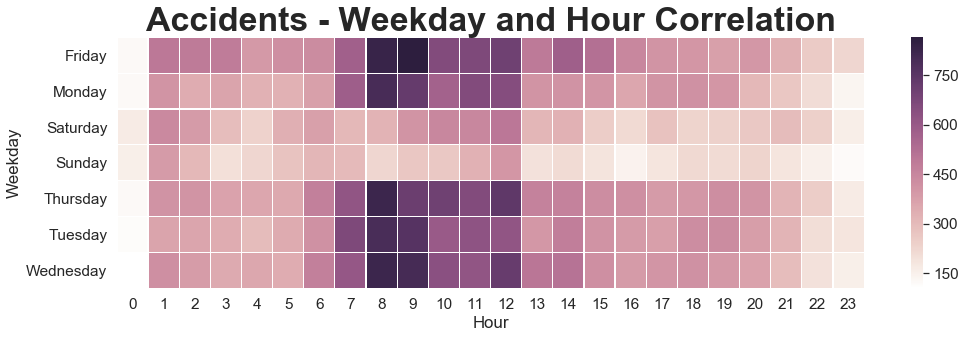

In [13]:
sns.set(font_scale=1.4)
plt.figure(figsize=(15, 5))

weekday = df['date'].dt.weekday_name
hour = df['date'].dt.hour
table = df.groupby([weekday, hour]).size()
table = table.rename_axis(['Weekday', 'Hour']).unstack('Hour')
cmap = sns.cubehelix_palette(light=1, as_cmap=True)


sns.heatmap(table, linewidths=0.2, cmap=cmap)
plt.title("Accidents - Weekday and Hour Correlation", fontsize=34).set_weight('bold')
plt.tight_layout()
plt.show()

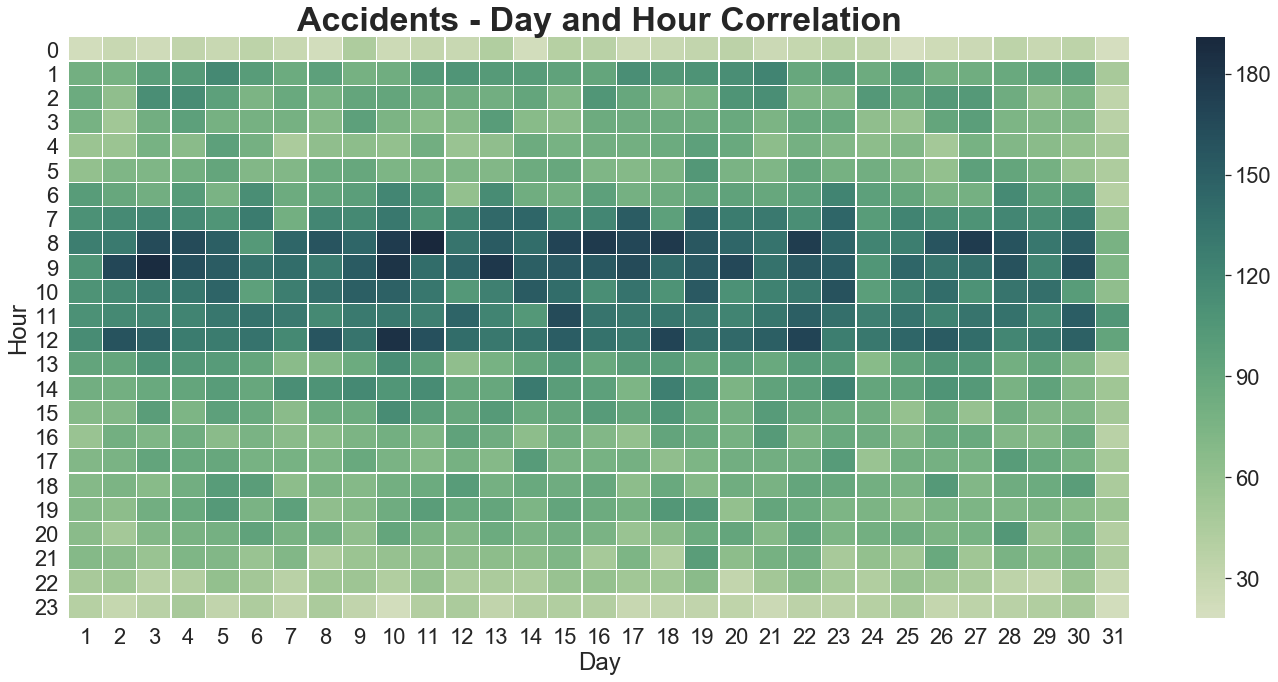

In [14]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))

day = df['date'].dt.day
hour = df['date'].dt.hour
table = df.groupby([day, hour]).size()
table = table.rename_axis(['Day', 'Hour']).unstack('Day')
cmap = sns.cubehelix_palette(7, rot=-.55, as_cmap=True)


sns.heatmap(table, linewidths=0.2, cmap=cmap)
plt.title("Accidents - Day and Hour Correlation", fontsize=34).set_weight('bold')
plt.tight_layout()
plt.show()

## On the two above correlation graphs we can see more clearly outlined conclusions that we have made earlier.

# Vehicles #

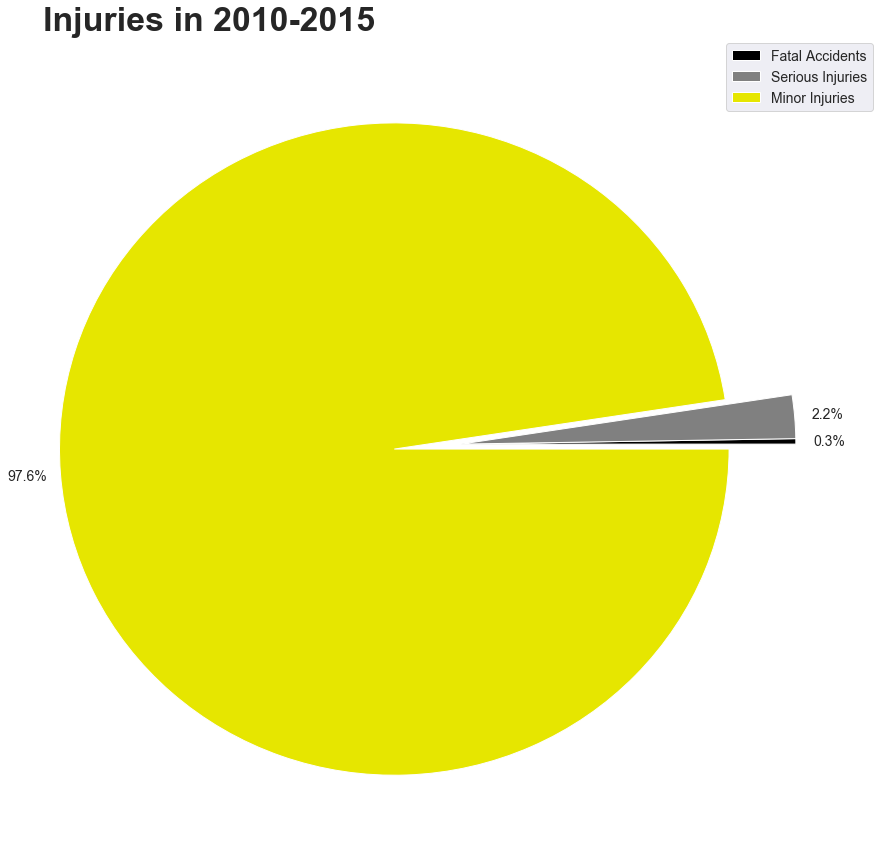

In [15]:
# Number of each injury type
import pylab

injuries = [fatal, serious, minor]

plt.figure(figsize=(15, 15))

colors=['black', 'grey', '#e6e600']
labels=['fatal', 'serious', 'minor']
plt.pie(injuries, colors=colors, labels=None, autopct='%1.1f%%',
        explode = (0, 0, 0.2), pctdistance=1.1, textprops={'fontsize': 14})

plt.legend(labels=['Fatal Accidents', 'Serious Injuries', 'Minor Injuries'], fontsize=14, loc='best')
plt.title('Injuries in 2010-2015', loc='left',fontsize=34).set_weight('bold')
pylab.ylabel('')
plt.show()


## The plot shows that only 0,3% of the injuries are fatal and 2,2% are serious. Most of them were minor injuries.


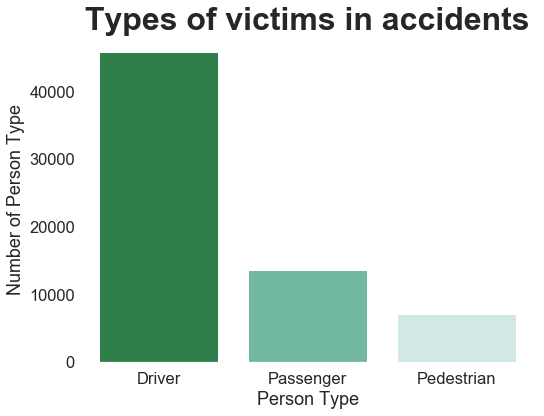

In [16]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8,6))


ptype = df['persontype'].value_counts()
ax = sns.barplot(x = ptype.index, y = ptype, palette="BuGn_r")

ax.set_facecolor('white')
plt.xlabel("Person Type")
plt.ylabel("Number of Person Type")
plt.title("Types of victims in accidents", fontsize=32).set_weight('bold')
plt.show()

## In around 50 thousand cases the driver was the victim and it's much more than the passenger or pedestrian



# Age and Sex

Text(0.5,1,'Gender Numbers')

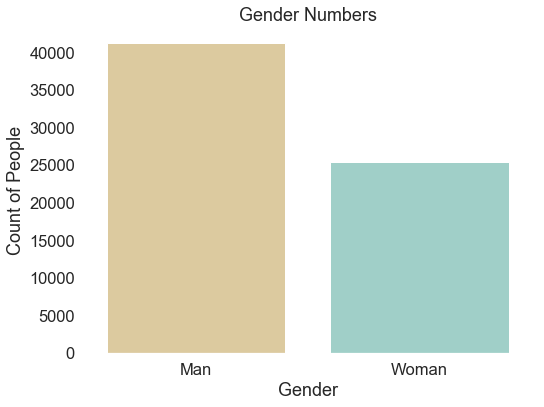

In [17]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8,6))

df['gender'].replace("Desconegut", "Woman", inplace=True)

sex = df['gender'].value_counts()
ax = sns.barplot(x=sex.index, y=sex, palette="BrBG")

ax.set_facecolor('white')
plt.xlabel("Gender")
plt.ylabel("Count of People")
plt.title("Gender Numbers")

## We can also easily affirm, that men causes two times more accidents that women


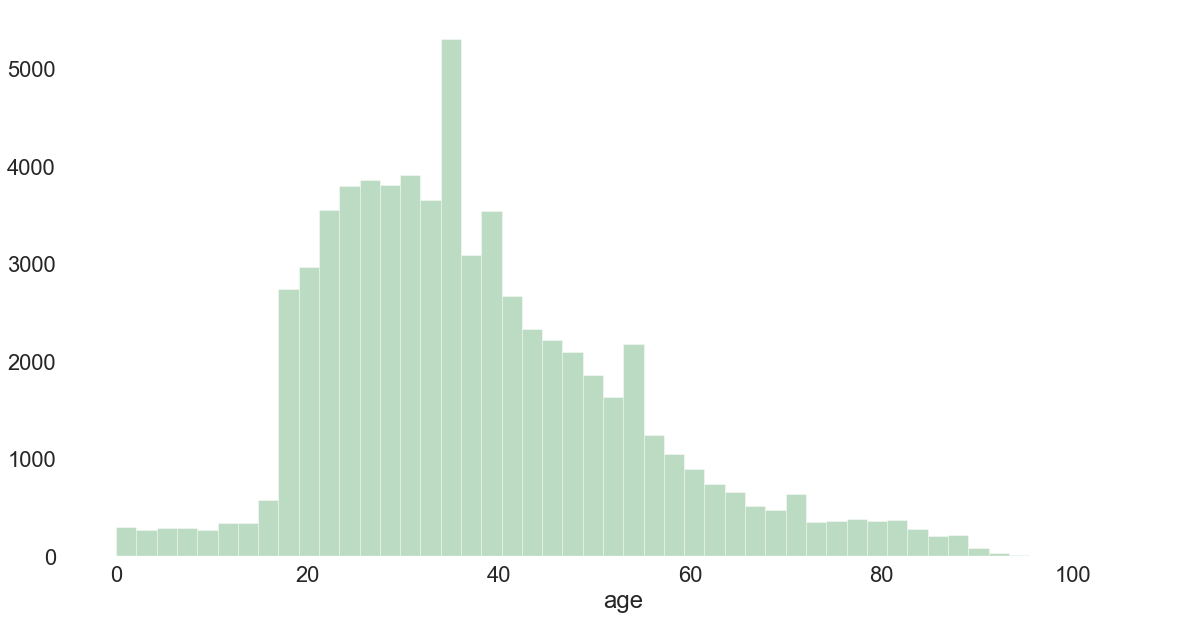

In [18]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))



age = df['age'].value_counts()
df.age.replace('Desconegut', '40', inplace=True)
df.age = df.age.apply(pd.to_numeric).astype(int)



ax = sns.distplot(df.age, kde=False, color='g')
ax.set_facecolor('white')
plt.show()

## Looking at distplot we can observe, that most of the time is the young person who causes the accident, also the most frequently occuring age group locates between 35 and 40 years old.



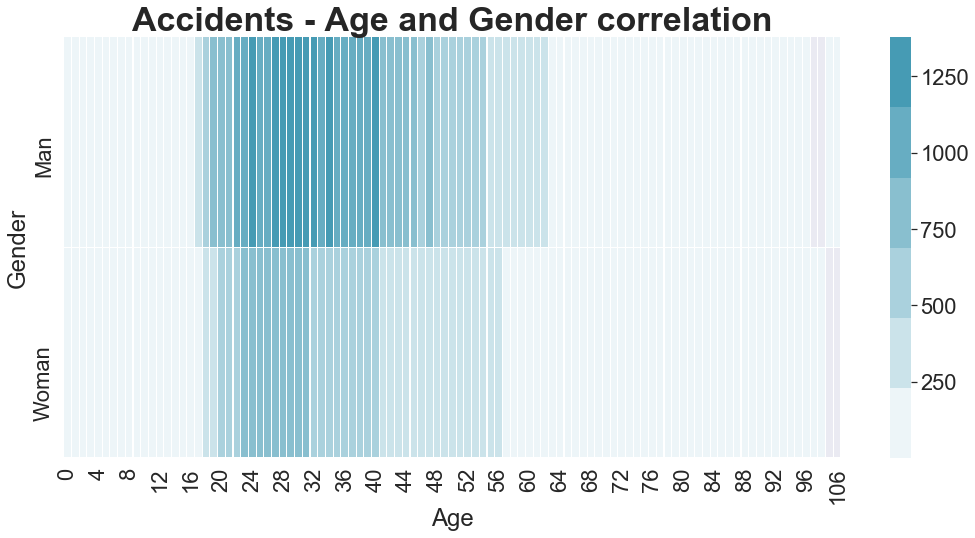

In [19]:
sns.set(font_scale=2)
plt.figure(figsize=(15, 8))

age = df['age']
gender = df['gender']
table = df.groupby([age, gender]).size()
table = table.rename_axis(['Age', 'Gender']).unstack('Age')
cmap = sns.light_palette((220, 80, 60), input="husl")


sns.heatmap(table, linewidths=0.1,cmap=cmap)
plt.title("Accidents - Age and Gender correlation", fontsize=34).set_weight('bold')
plt.tight_layout()
plt.show()

## Looking at correlation plot we can see it clearlier 


# Location #

In [20]:
import folium

# Define a map centered around Barcelona
barcelona_map = folium.Map(location=[41.38879, 2.15899], zoom_start=12)

# Display the map
barcelona_map

In [21]:
gdf = pd.read_csv('2017_map.csv')
gdf['date'] = pd.to_datetime(gdf['date'])

In [22]:
import folium
from folium.vector_layers import CircleMarker

# Create a map object of the city of Barcelona
barcelona_map= folium.Map(location=[41.38879, 2.15899], zoom_start=12)

# Display only accidents where serious injuries where recorded
for lat, lng, label in zip(gdf.latitude, gdf.longitude, gdf.serious_injuries.astype(str)):
    if label!='0':
        CircleMarker(
            [lat, lng],
            radius=3,
            color='red',
            fill=True,
            popup=label,
            fill_color='darkred',
            fill_opacity=0.6
        ).add_to(barcelona_map)
    
# Show map
barcelona_map

In [23]:
from folium import plugins

# Create a map object of the city of Barcelona
barcelona_map= folium.Map(location=[41.38879, 2.15899], zoom_start=12)

# Instantiate a mark cluster object for the car accidents
accidents = plugins.MarkerCluster().add_to(barcelona_map)

# Display only accidents where serious injuries where recorded
for lat, lng, label in zip(gdf.latitude, gdf.longitude, gdf.serious_injuries.astype(str)):
    if label!='0':
        folium.Marker(
            location=[lat, lng],
            icon=None,
            popup=label,
        ).add_to(accidents)

# Display map
barcelona_map

In [24]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))





from folium.plugins import HeatMapWithTime

# Create a map object of the city of Barcelona
barcelona_map= folium.Map(location=[41.38879, 2.15899], zoom_start=12)

# Nested list that contains the latitud and the longitud of the different accidents. 
hour_list = [[] for _ in range(24)]
for lat,log,hour in zip(gdf.latitude,gdf.longitude,gdf.date.dt.hour):
    hour_list[hour].append([lat,log]) 

# Labels indicating the hours
index = [str(i)+' Hours' for i in range(24)]

# Instantiate a heat map wiht time object for the car accidents
HeatMapWithTime(hour_list, index).add_to(barcelona_map)

title_html = '''
             <h3 align="bottom" style="font-size:20px"><b>Accidents with Serious injuries</b></h3>
             '''
# barcelona_map.get_root().html.add_child(folium.Element(title_html))

barcelona_map


# Accidents in Barcelona hour by hour




## Looking at the above timeline we can observe how the number of accidents with serious injuries increases from 8 hours, remaining high until 21 when it starts to decrease
